In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
import os

from pathlib import Path

parent = Path(os.path.abspath("")).resolve().parents[0]
if parent not in sys.path:
    sys.path.insert(0, str(parent))
    
from sklearn.model_selection import StratifiedKFold

from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler
from ml.utils.metrics import get_classification_metrics, get_probability_measures, get_lift_demotion_scores, find_all
import shap
shap.initjs()

In [2]:
def merge_strings_and_integers(val):
    try:
        return int(val)
    except:
        return 'other'

In [3]:
df = pd.read_csv("final_autof.csv")
df.drop([
    'MODE(consumptions.MS_METER_NBR)',
    'MODE(representations.SUPPLIER)',
    'MODE(representations.SUPPLIER_TO)',
], axis=1, inplace=True)
df.dropna(subset=['number_of_zeros'], inplace=True)


df['MODE(consumptions.BS_RATE)'] = df['MODE(consumptions.BS_RATE)'].apply(merge_strings_and_integers)
df = df.drop(['rec_id'], axis=1)
df = df.drop_duplicates()
df['MODE(requests.REQUEST_TYPE)'] = df['MODE(requests.REQUEST_TYPE)'].replace(0, 'unknown')
df = pd.get_dummies(df, columns=['MODE(requests.REQUEST_TYPE)'], prefix='MODE(requests.REQUEST_TYPE)')
df = pd.get_dummies(df, columns=['MODE(consumptions.BS_RATE)'], prefix='MODE(consumptions.BS_RATE)')
df = df.drop(['voltage'], axis=1)
df.fillna(0, inplace=True)
df.head()

Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.


,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def train(clf, X, y, cols):
    acc_scores = []
    prec_scores = []
    rec_scores = []
    f1_scores = []
    brier_scores, auc_roc_scores, pr_auc_scores = [], [], []
    lift_scores, demotion_scores, weighted_scores = [], [], []
    scaler = MinMaxScaler()
    print("Classifier: CATBOOST")
    assert len(X) == len(y)
    print("Number of samples:", len(X))
    print("Data bins", np.bincount(y))

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        scaler.fit(X_train)
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
        
        print("Shape", X_train.shape)
        
        
        print("bins", np.bincount(y_train))
        print("bins", np.bincount(y_test))

        clf.fit(X_train, y_train, verbose=False)

        y_pred = clf.predict(X_test)

        acc, precision, recall, f1 = get_classification_metrics(y_test.values, y_pred)

        y_scores = clf.predict_proba(X_test)
        idx = np.argmax(y_scores, axis=1)
        y_scores = np.where(idx == 0, 1 - y_scores[:, 0], y_scores[:, 1])


        brier, roc_auc, pr_auc = get_probability_measures(y_test.values, y_scores)

        num_ones = np.sum(y_test == 1)


        s1 = int(0.1 * num_ones)
        s2 = int(0.2 * num_ones)
        s3 = int(0.3 * num_ones)
        s4 = int(0.4 * num_ones)
        s5 = int(0.5 * num_ones)
        s6 = int(0.6 * num_ones)
        s7 = int(0.7 * num_ones)
        s8 = int(0.8 * num_ones)
        s9 = int(0.9 * num_ones)
        s10 = int(1 * num_ones)

        lift1, demotion1, weighted_score1 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s1)
        lift2, demotion2, weighted_score2 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s2)
        lift3, demotion3, weighted_score3 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s3)
        lift4, demotion4, weighted_score4 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s4)
        lift5, demotion5, weighted_score5 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s5)
        lift6, demotion6, weighted_score6 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s6)
        lift7, demotion7, weighted_score7 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s7)
        lift8, demotion8, weighted_score8 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s8)
        lift9, demotion9, weighted_score9 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s9)
        lift10, demotion10, weighted_score10 = get_lift_demotion_scores(y_test.values, y_scores,
                                                                    num_samples=s10)

        acc_scores.append(acc)
        prec_scores.append(precision)
        rec_scores.append(recall)
        f1_scores.append(f1)

        brier_scores.append(brier)
        auc_roc_scores.append(roc_auc)
        pr_auc_scores.append(pr_auc)

        lift_scores.append(lift4)
        demotion_scores.append(demotion4)
        weighted_scores.append(weighted_score4)

        print(f"0.1 -- Lift: {lift1:.4f}, Demotion: {demotion1:.4f}, Weighted: {weighted_score1:.4f}")
        print(f"0.2 -- Lift: {lift2:.4f}, Demotion: {demotion2:.4f}, Weighted: {weighted_score2:.4f}")
        print(f"0.3 -- Lift: {lift3:.4f}, Demotion: {demotion3:.4f}, Weighted: {weighted_score3:.4f}")
        print(f"0.4 -- Lift: {lift4:.4f}, Demotion: {demotion4:.4f}, Weighted: {weighted_score4:.4f}")
        print(f"0.5 -- Lift: {lift5:.4f}, Demotion: {demotion5:.4f}, Weighted: {weighted_score5:.4f}")
        print(f"0.6 -- Lift: {lift6:.4f}, Demotion: {demotion6:.4f}, Weighted: {weighted_score6:.4f}")
        print(f"0.7 -- Lift: {lift7:.4f}, Demotion: {demotion7:.4f}, Weighted: {weighted_score7:.4f}")
        print(f"0.8 -- Lift: {lift8:.4f}, Demotion: {demotion8:.4f}, Weighted: {weighted_score8:.4f}")
        print(f"0.9 -- Lift: {lift9:.4f}, Demotion: {demotion9:.4f}, Weighted: {weighted_score9:.4f}")
        print(f"1 -- Lift: {lift10:.4f}, Demotion: {demotion10:.4f}, Weighted: {weighted_score10:.4f}")

        find_all(y_test.values, y_scores,)
        
        print("Fold {} - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}"
                .format(len(acc_scores), acc_scores[-1], prec_scores[-1], rec_scores[-1], f1_scores[-1],
                        brier_scores[-1], auc_roc_scores[-1], pr_auc_scores[-1],
                        lift_scores[-1], demotion_scores[-1], weighted_scores[-1]))
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_test)
        shap.summary_plot(shap_values, X_test, plot_type='bar', max_display=len(cols), feature_names=cols, show=False)
        plt.tight_layout()
        plt.show()
        plt.close()
        
    
    print("Average - Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}, Brier: {:.4f}, AUC-ROC: {:.4f}, PR-AUC: {:.4f}, Lift: {:.4f}, Demotion: {:.4f}, Weighted: {:.4f}\n"
            .format(sum(acc_scores)/len(acc_scores), sum(prec_scores)/len(prec_scores),
                    sum(rec_scores)/len(rec_scores), sum(f1_scores)/len(f1_scores),
                    sum(brier_scores)/len(brier_scores), sum(auc_roc_scores)/len(auc_roc_scores), sum(pr_auc_scores)/len(pr_auc_scores),
                    sum(lift_scores)/len(lift_scores), sum(demotion_scores)/len(demotion_scores), sum(weighted_scores)/len(weighted_scores)))

In [5]:
clf = CatBoostClassifier(random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
print(len(df))
df = df.drop_duplicates()
print(len(df))

700519
700519


In [7]:
df.head()

,COUNT(consumptions),MAX(consumptions.CSS_MS_HS_USE),MEAN(consumptions.CSS_MS_HS_USE),MIN(consumptions.CSS_MS_HS_USE),NUM_UNIQUE(consumptions.BS_RATE),NUM_UNIQUE(consumptions.MS_METER_NBR),SKEW(consumptions.CSS_MS_HS_USE),STD(consumptions.CSS_MS_HS_USE),SUM(consumptions.CSS_MS_HS_USE),MODE(consumptions.DAY(MEASUREMENT_DATE)),...,MODE(consumptions.BS_RATE)_40,MODE(consumptions.BS_RATE)_41,MODE(consumptions.BS_RATE)_42,MODE(consumptions.BS_RATE)_43,MODE(consumptions.BS_RATE)_44,MODE(consumptions.BS_RATE)_52,MODE(consumptions.BS_RATE)_53,MODE(consumptions.BS_RATE)_54,MODE(consumptions.BS_RATE)_55,MODE(consumptions.BS_RATE)_other
0,4.0,135.0,64.250000,12.0,1.0,1.0,0.758461,54.389797,257.0,2.0,...,0,0,0,0,0,0,0,0,0,0
1,10.0,127.0,51.900000,0.0,1.0,2.0,0.783315,43.072162,519.0,2.0,...,0,0,0,0,0,0,0,0,0,0
2,12.0,6068.0,3924.166667,2446.0,1.0,1.0,0.574519,1012.516472,47090.0,28.0,...,0,0,0,0,0,0,0,0,0,0
3,6.0,1061.0,479.333333,7.0,2.0,1.0,0.020392,409.340282,2876.0,4.0,...,0,0,0,0,0,0,0,0,0,0
4,24.0,1247.0,536.833333,0.0,2.0,1.0,0.537625,335.364392,12884.0,4.0,...,0,0,0,0,0,0,0,0,0,0


Classifier: CATBOOST
Number of samples: 700519
Data bins [698967   1552]
Shape (560415, 88)
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 0.7097, Demotion: 1.0000, Weighted: 0.7968
0.2 -- Lift: 0.4677, Demotion: 1.0000, Weighted: 0.6274
0.3 -- Lift: 0.3656, Demotion: 1.0000, Weighted: 0.5559
0.4 -- Lift: 0.3065, Demotion: 1.0000, Weighted: 0.5145
0.5 -- Lift: 0.2581, Demotion: 1.0000, Weighted: 0.4806
0.6 -- Lift: 0.2527, Demotion: 1.0000, Weighted: 0.4769
0.7 -- Lift: 0.2396, Demotion: 1.0000, Weighted: 0.4677
0.8 -- Lift: 0.2339, Demotion: 1.0000, Weighted: 0.4637
0.9 -- Lift: 0.2115, Demotion: 1.0000, Weighted: 0.4480
1 -- Lift: 0.1968, Demotion: 1.0000, Weighted: 0.4377
There are 310 ones out of 140104 samples.
Finding all ones with a maximum of 1402 steps...
Found 35 out of 100 samples considered (sample scores: [0.17989176 0.18073011 0.18160653 0.18294044 0.18367078 0.18504613
 0.18702147 0.19271202 0.19407825 0.19439068]...
Found 76 out of 500 samples considered (sample

Found 307 out of 109500 samples considered (sample scores: [7.20256276e-05 7.20330188e-05 7.20339607e-05 7.20395007e-05
 7.20396232e-05 7.20413062e-05 7.20421749e-05 7.20483189e-05
 7.20490381e-05 7.20499419e-05]...
Found 307 out of 110000 samples considered (sample scores: [7.10211696e-05 7.10212261e-05 7.10215692e-05 7.10224626e-05
 7.10229117e-05 7.10261853e-05 7.10275893e-05 7.10284026e-05
 7.10284691e-05 7.10312306e-05]...
Found 307 out of 110500 samples considered (sample scores: [7.00281073e-05 7.00282690e-05 7.00287454e-05 7.00303421e-05
 7.00313836e-05 7.00344913e-05 7.00345022e-05 7.00369126e-05
 7.00393819e-05 7.00395804e-05]...
Found 307 out of 111000 samples considered (sample scores: [6.89177986e-05 6.89182808e-05 6.89185210e-05 6.89210220e-05
 6.89211630e-05 6.89234408e-05 6.89252698e-05 6.89265308e-05
 6.89268131e-05 6.89273388e-05]...
Found 307 out of 111500 samples considered (sample scores: [6.78281626e-05 6.78287980e-05 6.78290776e-05 6.78337133e-05
 6.78343899e-05 

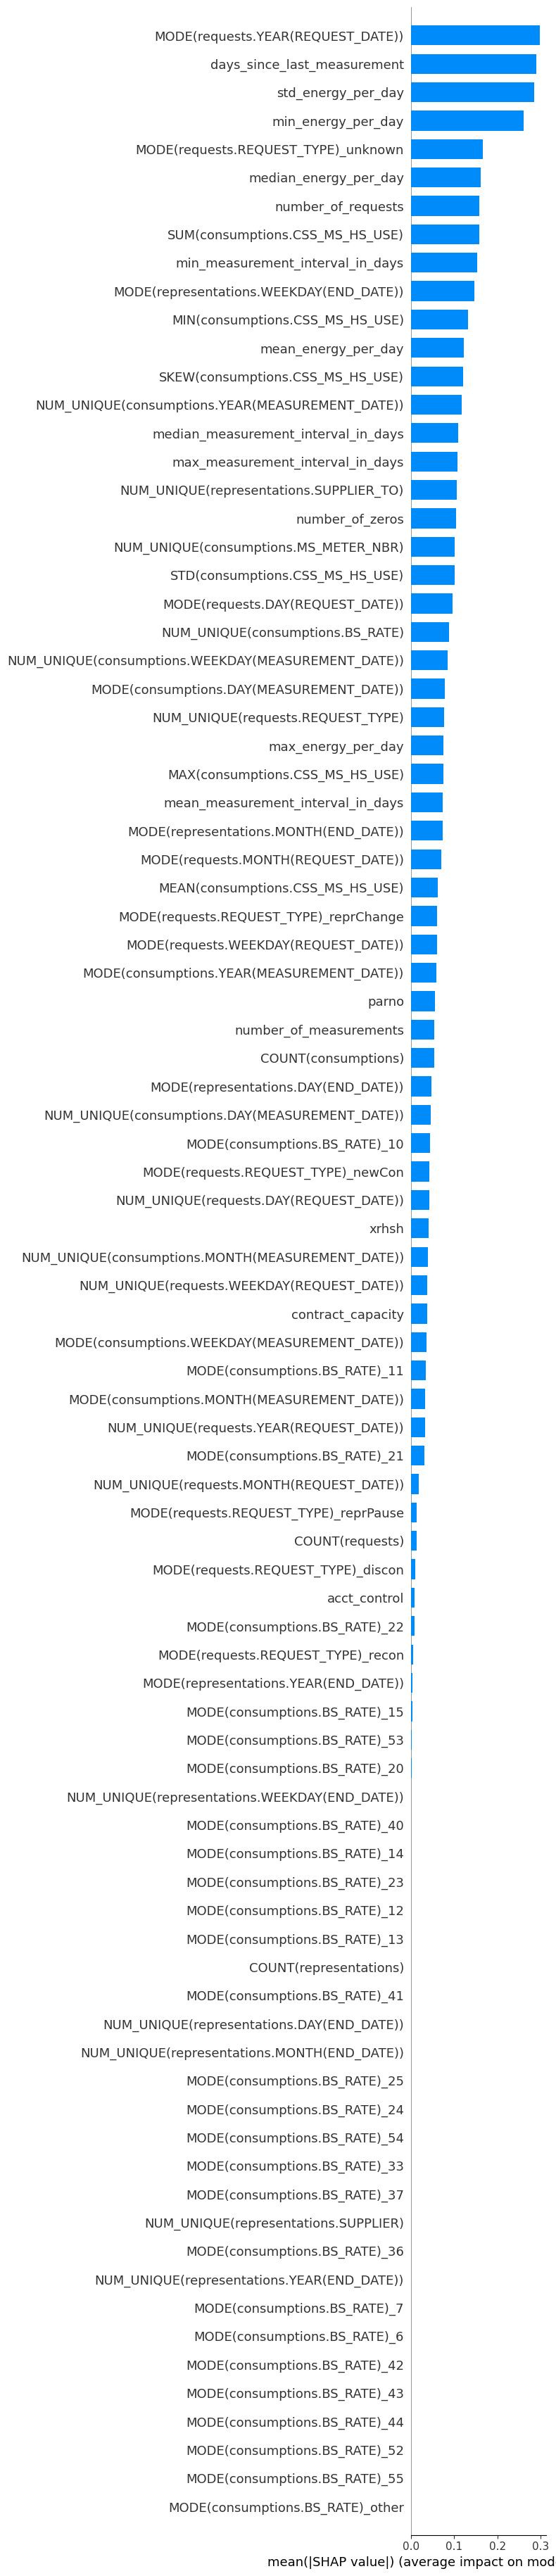

Shape (560415, 88)
bins [559173   1242]
bins [139794    310]
0.1 -- Lift: 0.6774, Demotion: 1.0000, Weighted: 0.7742
0.2 -- Lift: 0.4516, Demotion: 1.0000, Weighted: 0.6161
0.3 -- Lift: 0.3978, Demotion: 1.0000, Weighted: 0.5785
0.4 -- Lift: 0.3629, Demotion: 1.0000, Weighted: 0.5540
0.5 -- Lift: 0.3097, Demotion: 1.0000, Weighted: 0.5168
0.6 -- Lift: 0.2688, Demotion: 1.0000, Weighted: 0.4882
0.7 -- Lift: 0.2396, Demotion: 1.0000, Weighted: 0.4677
0.8 -- Lift: 0.2177, Demotion: 1.0000, Weighted: 0.4524
0.9 -- Lift: 0.2043, Demotion: 1.0000, Weighted: 0.4430
1 -- Lift: 0.1871, Demotion: 1.0000, Weighted: 0.4310
There are 310 ones out of 140104 samples.
Finding all ones with a maximum of 1402 steps...
Found 40 out of 100 samples considered (sample scores: [0.14417865 0.14449407 0.14599558 0.14892914 0.15069893 0.15123106
 0.15162791 0.15261061 0.15325939 0.15353901]...
Found 75 out of 500 samples considered (sample scores: [0.04692247 0.04696719 0.04706461 0.04716899 0.04717605 0.047195

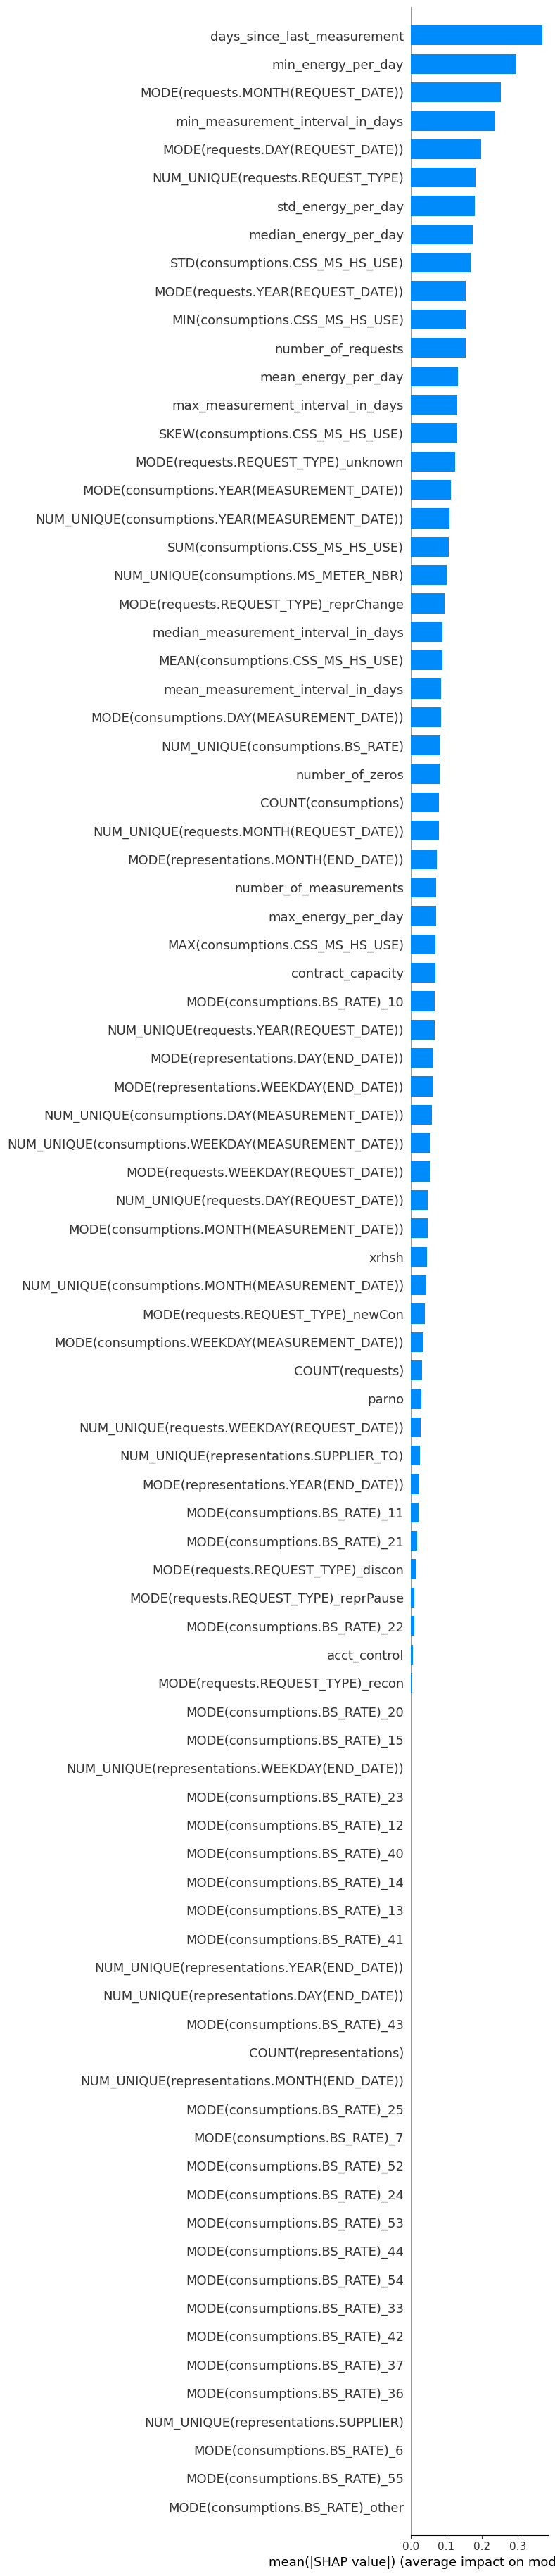

Shape (560415, 88)
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.6129, Demotion: 1.0000, Weighted: 0.7290
0.2 -- Lift: 0.4032, Demotion: 1.0000, Weighted: 0.5823
0.3 -- Lift: 0.3011, Demotion: 1.0000, Weighted: 0.5108
0.4 -- Lift: 0.2823, Demotion: 1.0000, Weighted: 0.4976
0.5 -- Lift: 0.2323, Demotion: 1.0000, Weighted: 0.4626
0.6 -- Lift: 0.1989, Demotion: 1.0000, Weighted: 0.4392
0.7 -- Lift: 0.1797, Demotion: 1.0000, Weighted: 0.4258
0.8 -- Lift: 0.1694, Demotion: 1.0000, Weighted: 0.4185
0.9 -- Lift: 0.1577, Demotion: 1.0000, Weighted: 0.4104
1 -- Lift: 0.1511, Demotion: 1.0000, Weighted: 0.4058
There are 311 ones out of 140104 samples.
Finding all ones with a maximum of 1402 steps...
Found 30 out of 100 samples considered (sample scores: [0.16451761 0.1658512  0.16589936 0.16608212 0.16613752 0.16931088
 0.17081612 0.17092125 0.17100627 0.17356801]...
Found 65 out of 500 samples considered (sample scores: [0.04642026 0.04643388 0.04648986 0.04652001 0.04657643 0.046634

Found 307 out of 97000 samples considered (sample scores: [8.73000643e-05 8.73030325e-05 8.73066036e-05 8.73066337e-05
 8.73082522e-05 8.73116377e-05 8.73136145e-05 8.73140116e-05
 8.73145623e-05 8.73165449e-05]...
Found 307 out of 97500 samples considered (sample scores: [8.60856414e-05 8.60875823e-05 8.60882586e-05 8.60890198e-05
 8.60911175e-05 8.60919677e-05 8.60929112e-05 8.60945285e-05
 8.60947908e-05 8.60970288e-05]...
Found 307 out of 98000 samples considered (sample scores: [8.48800323e-05 8.48803311e-05 8.48808543e-05 8.48852556e-05
 8.48855877e-05 8.48860987e-05 8.48893843e-05 8.48941345e-05
 8.48942886e-05 8.48945620e-05]...
Found 307 out of 98500 samples considered (sample scores: [8.37342937e-05 8.37358169e-05 8.37389008e-05 8.37410071e-05
 8.37445699e-05 8.37474122e-05 8.37474906e-05 8.37481382e-05
 8.37503499e-05 8.37509282e-05]...
Found 307 out of 99000 samples considered (sample scores: [8.25851539e-05 8.25858577e-05 8.25882311e-05 8.25940860e-05
 8.25951934e-05 8.259

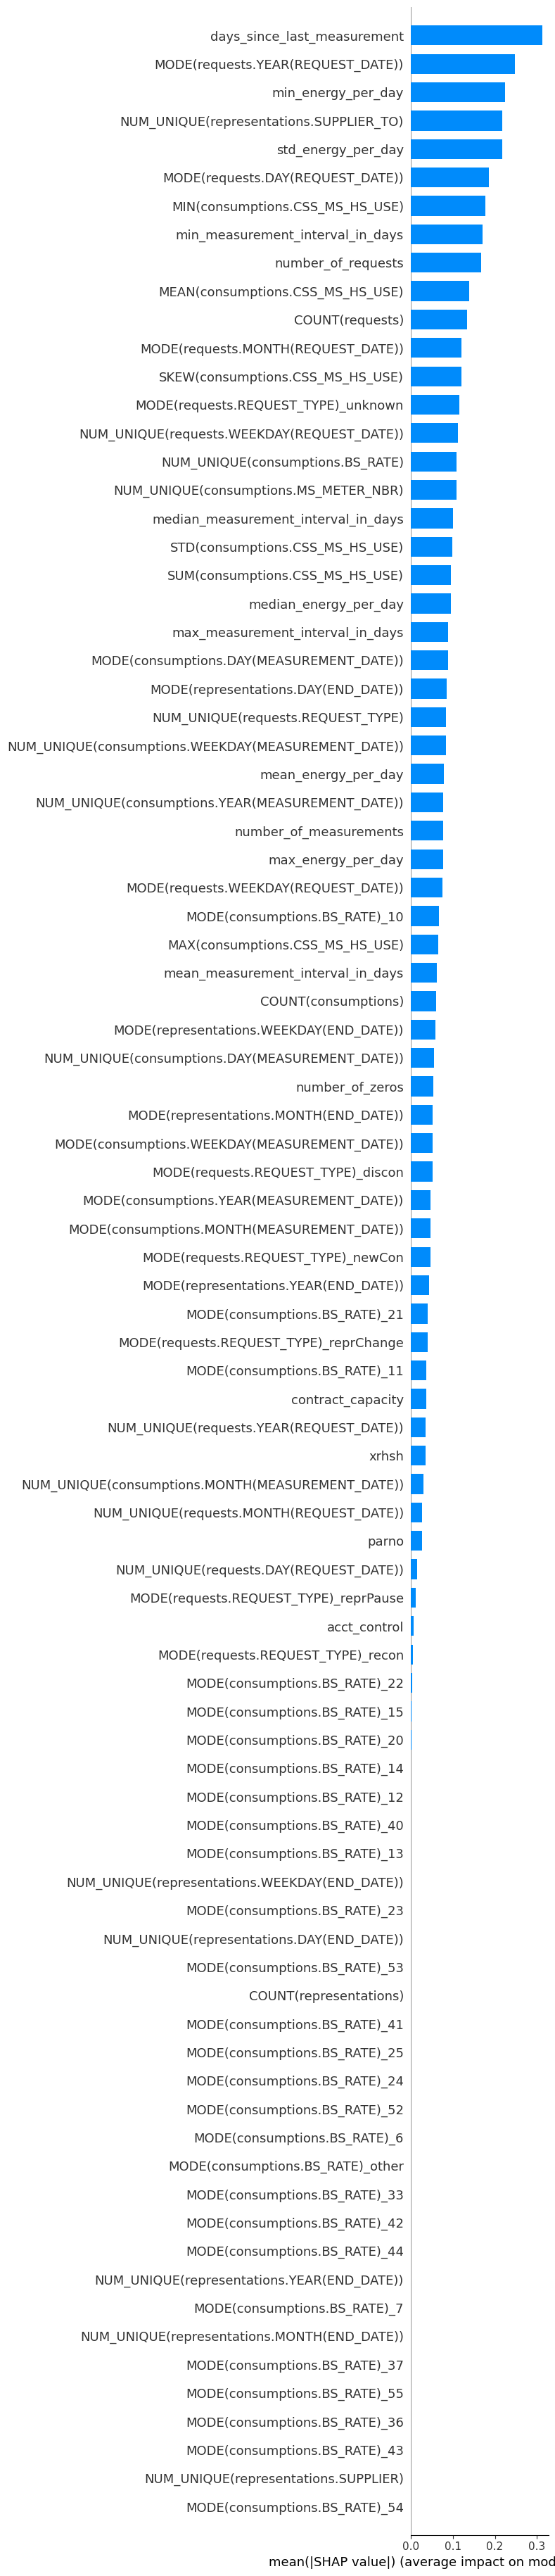

Shape (560415, 88)
bins [559174   1241]
bins [139793    311]
0.1 -- Lift: 0.4839, Demotion: 1.0000, Weighted: 0.6387
0.2 -- Lift: 0.3226, Demotion: 1.0000, Weighted: 0.5258
0.3 -- Lift: 0.2581, Demotion: 1.0000, Weighted: 0.4806
0.4 -- Lift: 0.2177, Demotion: 1.0000, Weighted: 0.4524
0.5 -- Lift: 0.1935, Demotion: 1.0000, Weighted: 0.4355
0.6 -- Lift: 0.1828, Demotion: 1.0000, Weighted: 0.4280
0.7 -- Lift: 0.1751, Demotion: 1.0000, Weighted: 0.4226
0.8 -- Lift: 0.1653, Demotion: 1.0000, Weighted: 0.4157
0.9 -- Lift: 0.1470, Demotion: 1.0000, Weighted: 0.4029
1 -- Lift: 0.1383, Demotion: 1.0000, Weighted: 0.3968
There are 311 ones out of 140104 samples.
Finding all ones with a maximum of 1402 steps...
Found 24 out of 100 samples considered (sample scores: [0.16548398 0.16553006 0.16569828 0.16605108 0.16853503 0.16938632
 0.1708315  0.17107275 0.17333875 0.17365062]...
Found 56 out of 500 samples considered (sample scores: [0.04559458 0.04568327 0.04572016 0.04605421 0.04606038 0.046065

Found 308 out of 108000 samples considered (sample scores: [7.66979717e-05 7.67010515e-05 7.67026720e-05 7.67076680e-05
 7.67113872e-05 7.67183570e-05 7.67198342e-05 7.67201451e-05
 7.67244906e-05 7.67247063e-05]...
Found 308 out of 108500 samples considered (sample scores: [7.55660063e-05 7.55784991e-05 7.55822795e-05 7.55838335e-05
 7.55853880e-05 7.55877224e-05 7.55892301e-05 7.55915793e-05
 7.55956613e-05 7.55973796e-05]...
Found 308 out of 109000 samples considered (sample scores: [7.43606723e-05 7.43616160e-05 7.43645509e-05 7.43652621e-05
 7.43666520e-05 7.43682660e-05 7.43735030e-05 7.43744716e-05
 7.43752659e-05 7.43764342e-05]...
Found 308 out of 109500 samples considered (sample scores: [7.31786641e-05 7.31809114e-05 7.31821279e-05 7.31823474e-05
 7.31888904e-05 7.31906294e-05 7.31911347e-05 7.31952574e-05
 7.31957014e-05 7.31973571e-05]...
Found 308 out of 110000 samples considered (sample scores: [7.20502103e-05 7.20526299e-05 7.20528216e-05 7.20549068e-05
 7.20560821e-05 

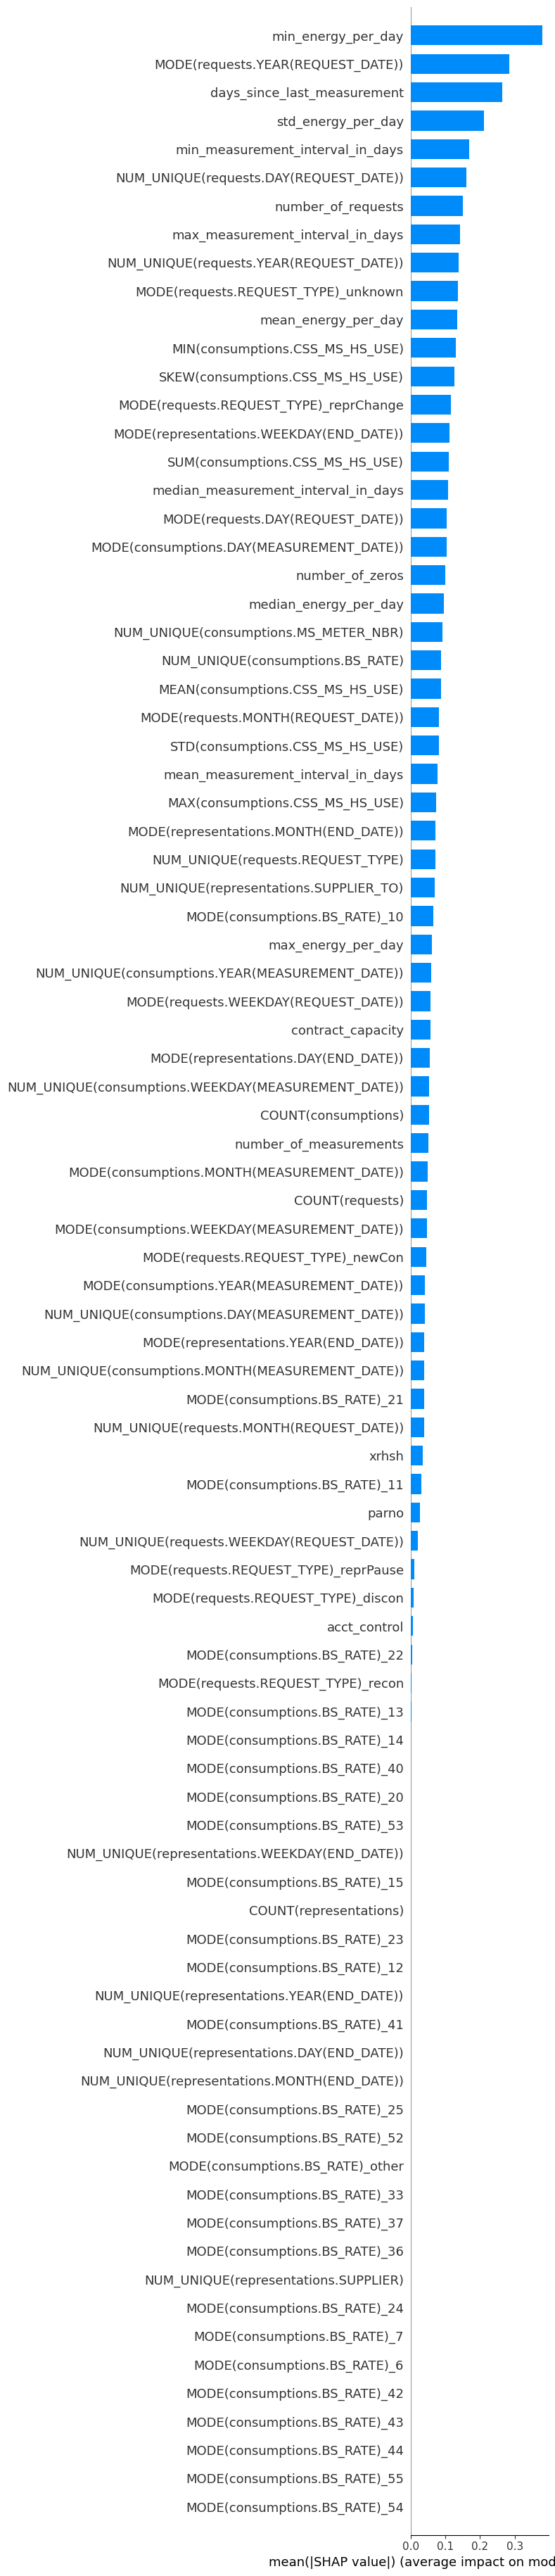

Shape (560416, 88)
bins [559174   1242]
bins [139793    310]
0.1 -- Lift: 0.5484, Demotion: 1.0000, Weighted: 0.6839
0.2 -- Lift: 0.4355, Demotion: 1.0000, Weighted: 0.6048
0.3 -- Lift: 0.3763, Demotion: 1.0000, Weighted: 0.5634
0.4 -- Lift: 0.3306, Demotion: 1.0000, Weighted: 0.5315
0.5 -- Lift: 0.2968, Demotion: 1.0000, Weighted: 0.5077
0.6 -- Lift: 0.2796, Demotion: 1.0000, Weighted: 0.4957
0.7 -- Lift: 0.2442, Demotion: 1.0000, Weighted: 0.4710
0.8 -- Lift: 0.2298, Demotion: 1.0000, Weighted: 0.4609
0.9 -- Lift: 0.2079, Demotion: 1.0000, Weighted: 0.4455
1 -- Lift: 0.1968, Demotion: 1.0000, Weighted: 0.4377
There are 310 ones out of 140103 samples.
Finding all ones with a maximum of 1402 steps...
Found 38 out of 100 samples considered (sample scores: [0.155459   0.15815117 0.15872925 0.15926517 0.15944367 0.15995136
 0.16080358 0.16112528 0.16363536 0.16480237]...
Found 71 out of 500 samples considered (sample scores: [0.04588725 0.04588884 0.04595041 0.04601273 0.04609923 0.046218

Found 306 out of 110000 samples considered (sample scores: [5.88822222e-05 5.88833964e-05 5.88835372e-05 5.88853148e-05
 5.88853985e-05 5.88916324e-05 5.88930789e-05 5.88984552e-05
 5.88989851e-05 5.88999642e-05]...
Found 306 out of 110500 samples considered (sample scores: [5.80083032e-05 5.80085705e-05 5.80105271e-05 5.80114004e-05
 5.80115215e-05 5.80162779e-05 5.80163572e-05 5.80189610e-05
 5.80191373e-05 5.80202917e-05]...
Found 306 out of 111000 samples considered (sample scores: [5.71346553e-05 5.71363884e-05 5.71377253e-05 5.71389315e-05
 5.71422537e-05 5.71428029e-05 5.71431561e-05 5.71432087e-05
 5.71438292e-05 5.71440368e-05]...
Found 306 out of 111500 samples considered (sample scores: [5.62792573e-05 5.62805086e-05 5.62812564e-05 5.62830525e-05
 5.62851257e-05 5.62864947e-05 5.62877230e-05 5.62891241e-05
 5.62893741e-05 5.62907784e-05]...
Found 306 out of 112000 samples considered (sample scores: [5.54179203e-05 5.54208045e-05 5.54219742e-05 5.54228724e-05
 5.54242255e-05 

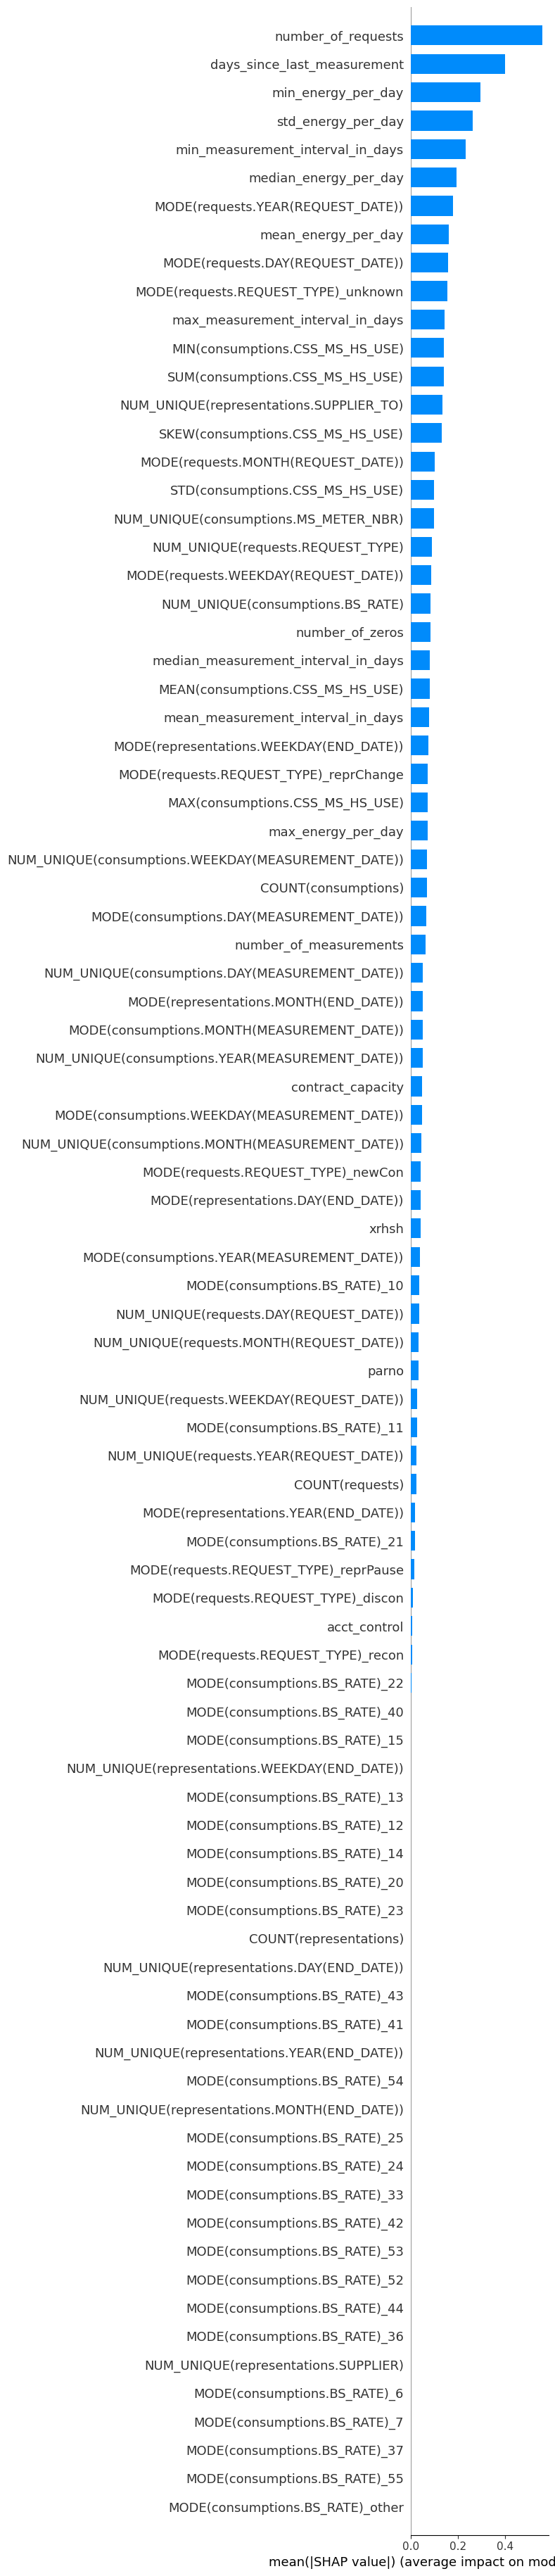

Average - Accuracy: 0.9979, Precision: 0.7650, Recall: 0.0567, F1: 0.1055, Brier: 0.0021, AUC-ROC: 0.8963, PR-AUC: 0.1246, Lift: 0.3000, Demotion: 1.0000, Weighted: 0.5100



In [8]:
X = df.drop(['target'], axis=1)
y = df['target']
cols = list(df.columns)
cols.remove('target')
train(clf, X, y, cols)